In [39]:
## Structural Estimation Problem Set 2 - GB Family and MLE
## by Alejandro Parraguez

import numpy as np

import scipy.stats as sts
import scipy.special as spc
import scipy.optimize as opt

import matplotlib.pyplot as plt

import pandas as pd
from pandas import DataFrame, Series

In [40]:
hcc = np.loadtxt('/Users/ale/Desktop/MAPSS/Winter/StructuralEstimation/PSet_2/clms.txt')

In [41]:
hcc

array([ 361.65,  123.04,  541.77, ...,   97.43,  186.88,  119.19])

In [85]:
avg = hcc.mean()
med = np.median(hcc)
mx = max(hcc)
mn = min(hcc)
std = hcc.std()

print('Mean =',avg,'Median =',med,
      'Maximum =',mx,'Minimum =',mn,'Standard Deviation =',std)


Mean = 720.277975327 Median = 172.21 Maximum = 227967.25 Minimum = 0.01 Standard Deviation = 3972.66375639


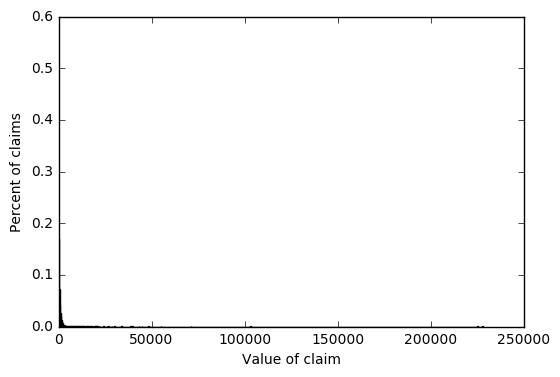

1.0


In [79]:
# Histogram Parameters

wght = (1/hcc.shape[0])*np.ones_like(hcc)

# Histogram all data

n, bin_cuts, patches = plt.hist(hcc,1000, weights = wght)
plt.xlabel('Value of claim')
plt.ylabel('Percent of claims')
plt.show()
print(n.sum())

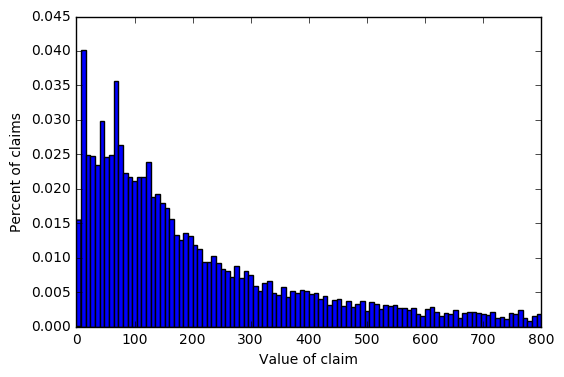

0.849420849421


In [77]:
# Histogram only less than 800

n, bin_cuts, patches = plt.hist(hcc,100, weights = wght,range=(0, 800))
plt.xlabel('Value of claim')
plt.ylabel('Percent of claims')
plt.show()
print(n.sum())

alpha_0= 0.0328727966942 beta_0= 21911.0647028
Log Likelihood with initial guess : -93555.3939035
alpha_MLE= 0.221755314084 beta_MLE= 21911.0646993
Log Likelihood with MLE estimates : -82076.4516057


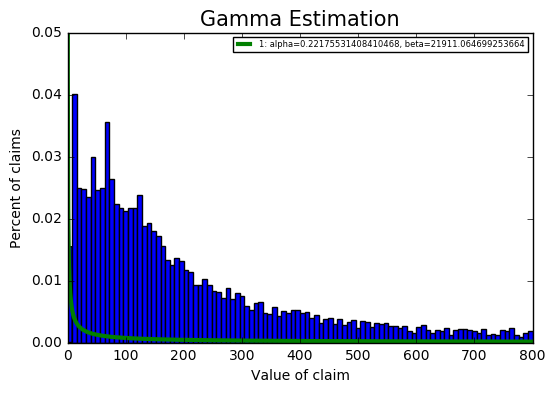

In [75]:
# (b) - MLE GA

# Initial Parameters 

def alphbet(df):

    exp = df.mean()
    var = df.var()
    
    beta_init = var/exp
    alph_init = exp/beta_init
    
    return alph_init, beta_init

aGA_0,bGA_0 = alphbet(hcc)

# Define the Log-Likelihood Function - Gamma

def log_lik_GA(xvect,alpha,beta):
    pdf_vect = sts.gamma.pdf(xvect,alpha,scale=beta)
    ln_pdf_vect = np.log(pdf_vect)
    log_lik_scal = ln_pdf_vect.sum()
    return log_lik_scal

# Define Criterion Function

def crit(prms,*args):
    alpha , beta = prms
    xvals = args
    log_lik_scal = log_lik_GA(xvals,alpha,beta)
    neg_log_lik_scal = - log_lik_scal
    
    return neg_log_lik_scal

# Optimize 

prms_vect = np.array([aGA_0,bGA_0])
mle_args = (hcc)
bnds_2 = ((0, None), (0, None))
estimates = opt.minimize(crit,prms_vect,args=mle_args,bounds=bnds_2)
aGA_MLE, bGA_MLE = estimates.x

lGA_0 = log_lik_GA(hcc,aGA_0,bGA_0)
lGA_MLE = log_lik_GA(hcc,aGA_MLE,bGA_MLE)

print('alpha_0=',aGA_0,'beta_0=',bGA_0)
print('Log Likelihood with initial guess :',lGA_0)
print('alpha_MLE=',aGA_MLE,'beta_MLE=',bGA_MLE)
print('Log Likelihood with MLE estimates :',lGA_MLE)

# Plot Estimated Distribution

x = hcc.sort()
plt.hist(hcc,100, weights = wght,range=(0, 800))
plt.plot(hcc,sts.gamma.pdf(hcc,aGA_MLE,scale=bGA_MLE),linewidth=3, 
         color='g',label='1: alpha={}, beta={}'.format(aGA_MLE,bGA_MLE))
plt.legend(loc='upper right',prop={'size':6})
plt.title('Gamma Estimation', fontsize=15)
plt.xlabel('Value of claim')
plt.ylabel('Percent of claims')
plt.xlim(0,800)
plt.ylim(0,0.05)
plt.show()


alpha_0= 0.221755314084 beta_0= 21911.0646993 m_0= 1
Log Likelihood with initial guess : -82076.4516057
alpha_MLE= 0.222276904301 beta_MLE= 21911.064472 m_MLE= 0.997647141587
Log Likelihood with MLE estimates : -82076.446472


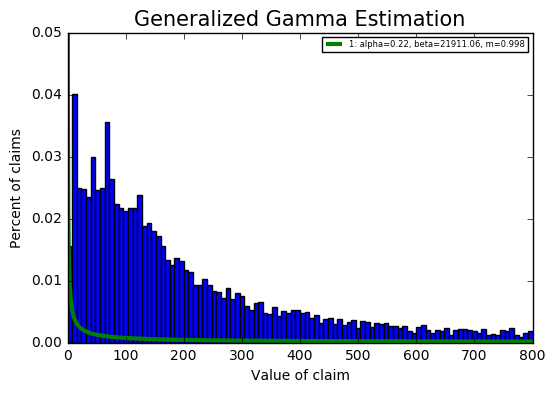

In [76]:
# (c) - MLE Generalized Gamma

# Initial Parameters 

mGG_0 = 1
aGG_0 = aGA_MLE
bGG_0 = bGA_MLE

# Define the Log-Likelihood Function - Generalized Gamma

def log_lik_GG(xvect,alpha,beta,m):
    pdf_vect = sts.gengamma.pdf(xvect,alpha,m,scale=beta)
    ln_pdf_vect = np.log(pdf_vect)
    log_lik_scal = ln_pdf_vect.sum()
    return log_lik_scal

# Define Criterion Function - Generalized Gamma

def crit_GG(prms,*args):
    alpha , beta, m = prms
    xvals = args
    log_lik_scal = log_lik_GG(xvals,alpha,beta,m)
    neg_log_lik_scal = -log_lik_scal
    
    return neg_log_lik_scal

# Optimize  - Generalized Gamma

GGpar_vect = np.array([aGG_0,bGG_0,mGG_0])
mle_args = (hcc)
bnds_3 = ((0, None), (0, None),(0, None))
estimates = opt.minimize( crit_GG , GGpar_vect , args=mle_args , bounds=bnds_3)
aGG_MLE, bGG_MLE, mGG_MLE = estimates.x

aGG_MLE_r = round(aGG_MLE,2)
bGG_MLE_r = round(bGG_MLE,2)
mGG_MLE_r = round(mGG_MLE,3)


lGG_0 = log_lik_GG(hcc,aGG_0,bGG_0,mGG_0)
lGG_MLE = log_lik_GG(hcc,aGG_MLE,bGG_MLE,mGG_MLE)

print('alpha_0=',aGG_0,'beta_0=',bGG_0,'m_0=',mGG_0)
print('Log Likelihood with initial guess :',lGG_0)

print('alpha_MLE=',aGG_MLE,'beta_MLE=',bGG_MLE,'m_MLE=',mGG_MLE)
print('Log Likelihood with MLE estimates :',lGG_MLE)

# Plot Estimated Distribution

x = hcc.sort()
plt.hist(hcc,100, weights = wght,range=(0, 800))
plt.plot(hcc,sts.gengamma.pdf(hcc,aGG_MLE,mGG_MLE,scale=bGG_MLE),linewidth=3, 
         color='g',label='1: alpha={}, beta={}, m={}'.format(aGG_MLE_r,bGG_MLE_r,mGG_MLE_r))
plt.legend(loc='upper right',prop={'size':6})
plt.title('Generalized Gamma Estimation', fontsize=15)
plt.xlabel('Value of claim')
plt.ylabel('Percent of claims')
plt.xlim(0,800)
plt.ylim(0,0.05)
plt.show()


a_0= 0.997647141587 b_0= 179043492.206 p_MLE= 0.2228011238 q_0= 8000
Log Likelihood with initial guess : -82076.5800745
a_MLE= 0.691803183474 b_MLE= 179043492.206 p_MLE= 1.01879283573 q_MLE= 7989.43557024
Log Likelihood with MLE estimates : -76432.3265338


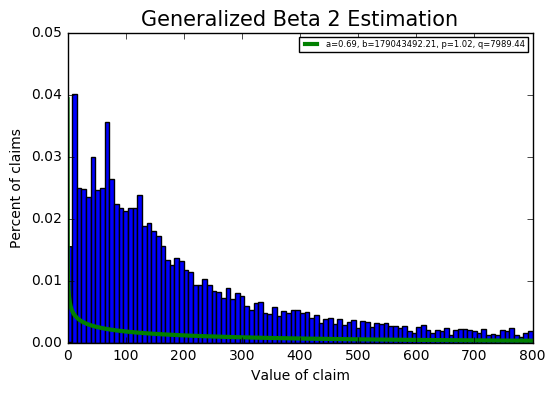

In [94]:
# (d) - MLE Generalized Beta 2

# Initial Parameters 

# Running optimize with q_0 = 10000 would return the same initial guesses
# as the MLE estimates. When using q_0 = 8000, the command finds a lower 
# value for the criterion function. Around 10000 the criterion function
# must be too flat. 

qGB2_0 = 8000
bGB2_0 = (qGB2_0**(1/mGG_MLE))*bGG_MLE
aGB2_0 = mGG_MLE
pGB2_0 = aGG_MLE/mGG_MLE


# Construct GB2 distribution from Beta Prime

def genbetaprime_pdf(xvect,a,b,p,q):
    nom = abs(a) * (xvect**(a*p-1)) 
    den = (b**(a*p)) * spc.beta(p,q) * ((1+((xvect/b)**a))**(p+q)) 
    gb2_pdf = nom/den
    return gb2_pdf

# Define the Log-Likelihood Function - Generalized Beta 2

def log_lik_GB2(xvect,a,b,p,q):
    pdf_vect = genbetaprime_pdf(xvect,a,b,p,q)
    ln_pdf_vect = np.log(pdf_vect)
    log_lik_scal = ln_pdf_vect.sum()
    return log_lik_scal

# Define Criterion Function - Generalized Beta

def crit_GB2(prms,*args):
    a,b,p,q = prms
    xvals = args
    log_lik_scal = log_lik_GB2(xvals,a,b,p,q)
    neg_log_lik_scal = - log_lik_scal
    
    return neg_log_lik_scal

# Optimize  - Generalized Beta

GB2par_vect = np.array([aGB2_0,bGB2_0,pGB2_0,qGB2_0])
mle_args = (hcc)
bnds_4 = ((0, None), (0, None),(0, None),(0, None))
estimates = opt.minimize( crit_GB2 , GB2par_vect , args=mle_args , bounds=bnds_4)
aGB2_MLE,bGB2_MLE,pGB2_MLE,qGB2_MLE = estimates.x

aGB2_MLE_r = round(aGB2_MLE,2)
bGB2_MLE_r = round(bGB2_MLE,2)
pGB2_MLE_r = round(pGB2_MLE,2)
qGB2_MLE_r = round(qGB2_MLE,2)

lGB2_0 = log_lik_GB2(hcc,aGB2_0,bGB2_0,pGB2_0,qGB2_0)
lGB2_MLE = log_lik_GB2(hcc,aGB2_MLE,bGB2_MLE,pGB2_MLE,qGB2_MLE)

print('a_0=',aGB2_0,'b_0=',bGB2_0,'p_MLE=',pGB2_0,'q_0=',8000)
print('Log Likelihood with initial guess :',lGB2_0)
print('a_MLE=',aGB2_MLE,'b_MLE=',bGB2_MLE,'p_MLE=',pGB2_MLE,'q_MLE=',qGB2_MLE)
print('Log Likelihood with MLE estimates :',lGB2_MLE)

# Plot Estimated Distribution

x = hcc.sort()
plt.hist(hcc,100, weights = wght,range=(0, 800))
plt.plot(hcc,genbetaprime_pdf(hcc,aGB2_MLE,bGB2_MLE,pGB2_MLE,qGB2_MLE),linewidth=3, 
         color='g',label='a={}, b={}, p={}, q={}'.format(aGB2_MLE_r,bGB2_MLE_r,pGB2_MLE_r,qGB2_MLE_r))
plt.legend(loc='upper right',prop={'size':6})
plt.title('Generalized Beta 2 Estimation', fontsize=15)
plt.xlabel('Value of claim')
plt.ylabel('Percent of claims')
plt.xlim(0,800)
plt.ylim(0,0.05)
plt.show()


In [72]:
# (e) - Likelihood Ratio Test

    # Estimates from (b) and (d)
    
aGB_b = 1
bGB_b = 9990*bGA_MLE
pGB_b = aGA_MLE
qGB_b = 9990
    
h_0_b = log_lik_GB2(hcc,aGB_b,bGB_b,pGB_b,qGB_b)
h_MLE = log_lik_GB2(hcc,aGB2_MLE,bGB2_MLE,pGB2_MLE,qGB2_MLE)

LR_GA = 2*(h_MLE-h_0_b)
pval_GA = 1 - sts.chi2.cdf(LR_GA,4)

pval_GA
    

0.0

In [73]:
    # Estimates from (c) and (d)
    
aGB_c = mGG_MLE
bGB_c = (9990**(1/mGG_MLE))*bGG_MLE
pGB_c = aGG_MLE
qGB_c = 9990

h_0_c = log_lik_GB2(hcc,aGB_c,bGB_c,pGB_c,qGB_c)
LR_GG = 2*(h_MLE-h_0_c)
pval_GG = 1 - sts.chi2.cdf(LR_GG,4)

pval_GG


0.0

In [102]:
# (f) - Using the estimates

import scipy.integrate as integrate

prob_GA = 1-sts.gamma.cdf(1000,aGA_MLE,scale=bGA_MLE)

def integrand(x):
    return genbetaprime_pdf(x,aGB2_MLE,bGB2_MLE,pGB2_MLE,qGB2_MLE)

prob_GB2, error = integrate.quad(integrand,1000,10000)

print('P(claim>1000|GA) = ',prob_GA,'P(claim>1000|GB2) = ',prob_GB2)


P(claim>1000|GA) =  0.451959730953 P(claim>1000|GB2) =  0.16092780065014217
